In [236]:
from commonfunctions import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


- **Preprocessing**: Enhance bubbles using adaptive thresholding and morphological operations (closing/dilation) to ensure solid shapes.
- **ROI Extraction**: Detect the student ID box and the answers area using contour analysis (looking for large rectangular regions).
- **Generic Bubble Detection**:
    - Use `cv2.findContours` to find all potential bubbles.
    - Filter contours by area, aspect ratio, and circularity.
    - Group bubbles into rows (questions) and columns (choices) based on their spatial coordinates.
- **Mark Detection**: Calculate the mean intensity or pixel density of each bubble area to identify the filled choice.
- **Grading & Export**: Compare results with the model answer and export to Excel using `export_excel` from `commonfunctions`.


In [245]:
def detect_inner_box(image):
    # If the image is already grayscale, use it; otherwise, convert it.
    if len(image.shape) == 3:
        gray = rgb2gray(image)
    else:
        gray = image
    
    # Scale to 0-255 uint8 if necessary
    if gray.dtype != np.uint8:
        gray = (gray * 255).astype(np.uint8)

    # Use a fixed threshold to find the black borders
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return image

    # Sort contours by area and get the largest one
    c = sorted(contours, key=cv2.contourArea, reverse=True)
    
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)

    # We are looking for a rectangle (4 points)
    if len(approx) == 4:
    # Warp the image to this inner rectangle
    
        return four_point(image, approx.reshape(4, 2))
            
    # return image


(4032, 3024, 3)
(3469, 2788)


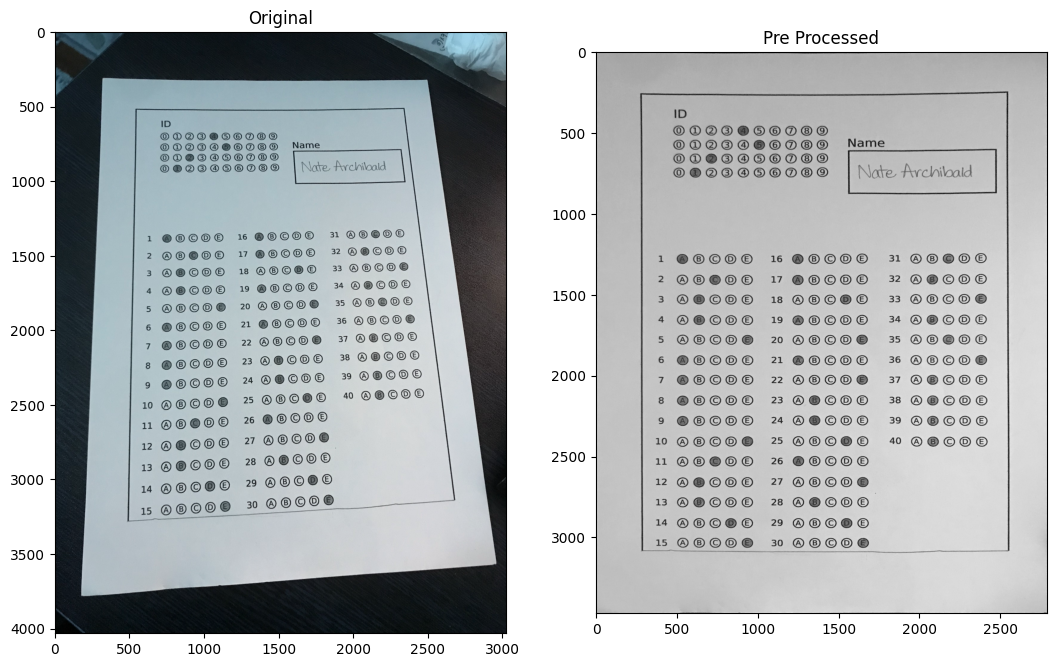

In [251]:
## Read Image
image = cv2.imread("./Bubble_Sheet_Dataset/3/ID4Q40CH5/IMG_2029.jpg")
print(image.shape)
pre_processed_image = preprocessing(image)
print(pre_processed_image.shape)
show_images([image, pre_processed_image], ["Original", "Pre Processed"])

In [252]:
def find_bubbles(image_gray):
    """
    Detects bubbles in a grayscale image and returns them grouped by rows.
    This approach is generic and handles different numbers of questions/choices.
    """
    # convert the gray image (0 -> 1) to uint8 type and multiply by 255 becuase adaptiveThreshold function
    # deals with this type
    img_uint8 = (image_gray * 255).astype(np.uint8) if image_gray.dtype != np.uint8 else image_gray
    
    # get the binary image image because findCountours deals with binary only
    # we chose the invesrsed binary threshold because this is the type expected by findContours function
    _, binary_image = cv2.threshold(img_uint8, 165, 255, cv2.THRESH_BINARY_INV)

    # apply closing to fill the gaps in the circles which are marked.
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    closed = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
    show_images([image_gray, binary_image, closed], ['Original Gray', 'Inverse Binary Image', 'Closed Image'])

    # contours is a Python list of all the contours in the image.
    # Each individual contour is a Numpy array of (x,y) coordinates of boundary points of the object.
    # [[(x1,y1), (x2, y2)], [(x1,y1), (x2, y2)], [(x1,y1), (x2, y2)]]
    # we use RETR_EXTERNAL to only find external boundaries and ignore inner circles in letters like 'd' 
    # and numbers like '9' or '0'
    contours, _ = cv2.findContours(closed, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    bubbles = []
    for cnt in contours:
        (x, y, w, h) = cv2.boundingRect(cnt)

        # The ratio of the width to the height of the bubble
        # A perfect circle or square has an aspect ratio of 1.0.
        aspect_ratio = w / float(h) 

        ## countour area (number of pixels in this contour)
        area = cv2.contourArea(cnt) 

        perimeter = cv2.arcLength(cnt, True)
        if perimeter == 0: continue

        circularity = 4 * np.pi * (area / (perimeter * perimeter))
        
        # Filter based on area and aspect ratio
        if  circularity >= 0.77 and area > 1000 and aspect_ratio > 0.83:
            bubbles.append((x, y, w, h, cnt))
            
    if not bubbles:
        return []

    # group the bubbles into rows (Questions)
    # sort bubbles by their top-to-bottom position (y-coordinate)
    bubbles = sorted(bubbles, key=lambda b: b[1])
    
    rows = []
    if bubbles:
        current_row = [bubbles[0]]
        for i in range(1, len(bubbles)):
            # If the current bubble's Y is close to the previous one, it's the same row
            # threshold is roughly half the height of a bubble
            if abs(bubbles[i][1] - current_row[-1][1]) < (bubbles[i][3] / 2):
                current_row.append(bubbles[i])
            else:
                # Sort the completed row by left-to-right (x-coordinate)
                rows.append(sorted(current_row, key=lambda b: b[0]))
                current_row = [bubbles[i]]
        rows.append(sorted(current_row, key=lambda b: b[0]))
        
    return rows

# def get_marked_choice(row_bubbles, image_gray):
#     """
#     Identifies which bubble in a row is marked based on pixel density.
#     """
#     marked_index = -1
#     max_density = -1
    
#     # Ensure image is in [0, 1] range for consistent density calculation
#     if image_gray.max() > 1.0:
#         image_gray = image_gray / 255.0
        
#     for i, (x, y, w, h, cnt) in enumerate(row_bubbles):
#         # Create a mask for this specific bubble contour
#         mask = np.zeros(image_gray.shape, dtype="uint8")
#         cv2.drawContours(mask, [cnt], -1, 255, -1)
        
#         # Calculate the average darkness in this area
#         mask_bool = mask > 0
#         mean_val = np.mean(image_gray[mask_bool])
        
#         # The darker the bubble (lower mean intensity), the more likely it's filled
#         density = 1.0 - mean_val
        
#         if density > max_density:
#             max_density = density
#             marked_index = i
            
#     # Threshold to ensure it's actually marked (not empty)
#     if max_density < 0.5: 
#         return -1
        
#     return marked_index


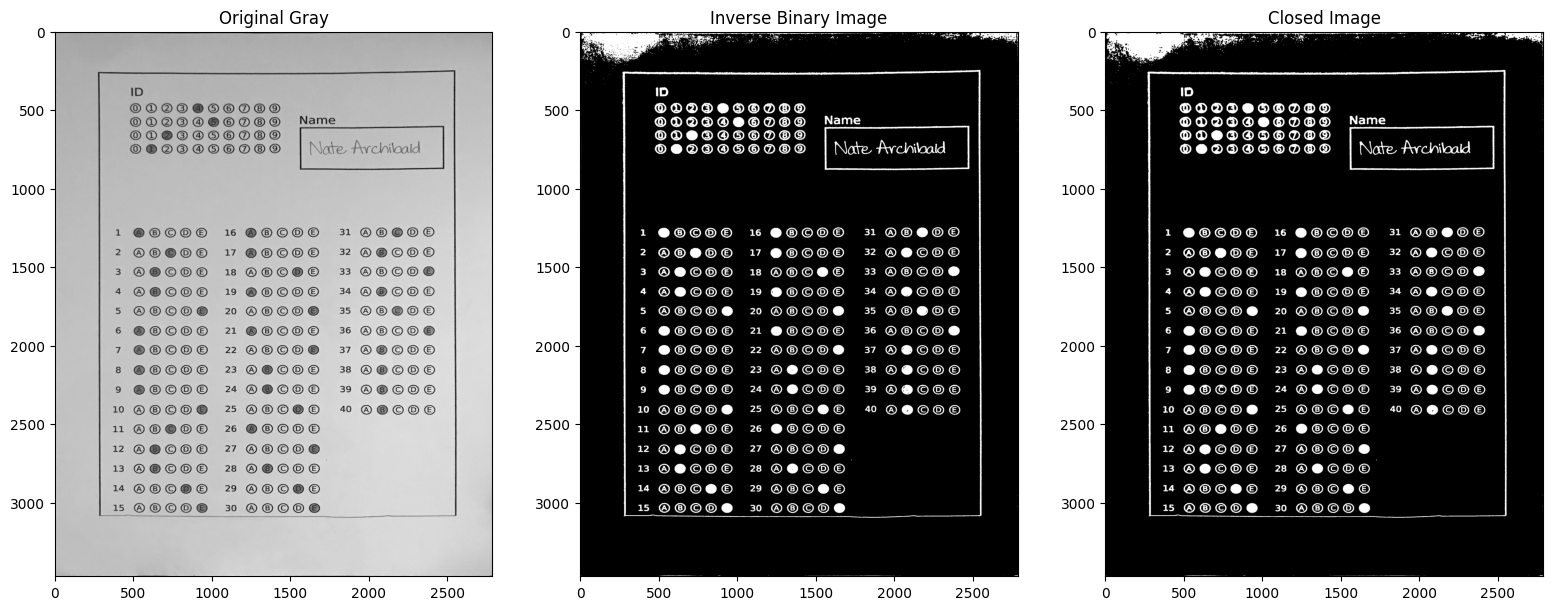

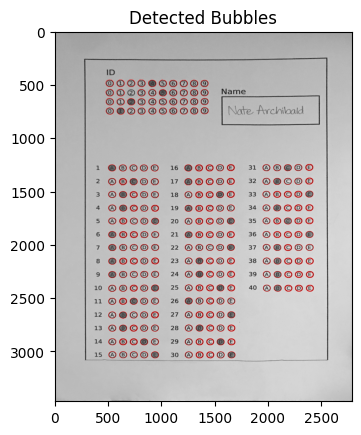

In [253]:
rows = find_bubbles(pre_processed_image)

# Create a copy to draw on (convert grayscale back to RGB so we can draw in color)
viz_image = cv2.cvtColor((pre_processed_image * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)

# 3. Loop through the detected rows and bubbles
for row in rows:
    for (x, y, w, h, cnt) in row:
        # Draw a green rectangle around the detected bubble
        # cv2.rectangle(viz_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        # Optionally draw the actual contour in red
        cv2.drawContours(viz_image, [cnt], -1, (255, 0, 0), 2)

# 4. Show the result
show_images([viz_image], ["Detected Bubbles"])